In [ ]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from google.colab import drive
import gc
from sklearn.metrics import classification_report
from google.colab import files


In [ ]:


train_id = pd.read_csv('drive/MyDrive/train_identity.csv')
train_transaction = pd.read_csv('drive/MyDrive/train_transaction.csv')

print(f'Size of train_id - rows: {train_id.shape[0]}, columns: {train_id.shape[1]}')
print(f'Size of train_transaction - rows:{train_transaction.shape[0]}, columns: {train_transaction.shape[1]}')
# combine the data and work with the whole dataset
train = train_transaction.merge(train_id,on=['TransactionID'],how='left') 
print(f'Size of train - rows : {train.shape[0]}, columns : {train.shape[1]}')

train.shape


Size of train_id - rows: 144233, columns: 41
Size of train_transaction - rows:590540, columns: 394
Size of train - rows : 590540, columns : 434


(590540, 434)

a lot of memory usage

In [ ]:
train_GB = train.memory_usage(deep = True).sum()/1024**3 
print(f'train dataframe is using {train_GB:.2f} GB of memory storage')

train dataframe is using 2.51 GB of memory storage


In [ ]:
del train_id
del train_transaction
gc.collect

<function gc.collect>

In [ ]:
train=train.truncate(after=50000)
train.shape

(50001, 434)

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
100000,3087000,0,2006416,34.105,C,12778,500.0,185.0,mastercard,224.0,...,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
100001,3087001,0,2006426,73.749,C,3154,408.0,185.0,mastercard,224.0,...,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
100002,3087002,0,2006462,107.950,W,2772,512.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,3087003,0,2006469,124.500,W,11473,528.0,150.0,visa,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,3087004,0,2006499,100.000,W,14819,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


reduce memory usage

In [ ]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(train)

Initial memory usage of dataframe is 217.69 MB/0.21 GB
Memory usage after optimization is: 42.01 MB/0.04 GB
Decreased by 80.7%


a lot of missing data

In [ ]:
total_mv= train.isnull().sum().to_frame()                        #round to whole number 
percent_mv = (train.isnull().sum()/train.isnull().count()*100)   # round to 2 dp

pd.concat([total_mv, percent_mv], axis=1, keys=['Total Missing Values', 'Percent']).transpose()

,,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total Missing Values,0,0.0,0.0,0.0,0.0,0.0,0.0,680.000000,0.0,1.000,266.000000,...,30459.000000,36899.000000,37739.00000,36897.000000,30432.000000,30432.000000,30432.000000,30432.000000,30436.000000,32781.000000
Percent,0,0.0,0.0,0.0,0.0,0.0,0.0,1.359973,0.0,0.002,0.531989,...,60.916782,73.796524,75.47649,73.792524,60.862783,60.862783,60.862783,60.862783,60.870783,65.560689


unbalanced data

Target Column : isFraud


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


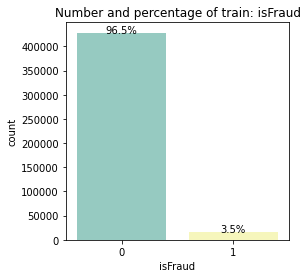

In [ ]:
target_count = train['isFraud'].value_counts()
target_percent = train['isFraud'].value_counts()/len(train)

print('Target Column : isFraud')
pd.concat([ target_count, target_percent], axis=1, keys=['Count', 'Percent'])
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100*height/total),
                ha="center") 
    plt.show() 
plot_count('isFraud',  'train: isFraud', df=train, size=1)

Correlation Study (Numerical Features Only)

In [ ]:
cat_features = ['ProductCD','card4','card6', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_15',
                'id_16','id_23','id_27','id_28','id_29','id_30','id_31',
                'id_33','id_34','id_35','id_36','id_37','id_38']

num_features = [x for x in train.columns.values[2:] if x not in cat_features]  #slicing from 2 onwards ( first 2 columns are identifier and target)

features = num_features + cat_features

print('Categorical features :', len(cat_features))
print('Numerical features : ',len(num_features))

Categorical features : 31
Numerical features :  401


encoding categorical features

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
y=train['isFraud']

scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown='ignore')


column_trans = ColumnTransformer(
    [('ohe', ohe, cat_features)], remainder='passthrough', n_jobs=-1)
  


t = pd.DataFrame(column_trans.fit_transform(train,y))
train.head()
train=train.join(t)
train.shape




(50001, 1847)

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
450000,3437000,1,11476547,28.28125,C,3213,459.0,185.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450001,3437001,0,11476568,378.00000,W,7676,512.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450002,3437002,0,11476575,250.00000,W,9936,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450003,3437003,0,11476592,200.00000,R,17333,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450004,3437004,0,11476627,378.50000,W,12652,555.0,150.0,visa,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


scaling numerical features

In [ ]:

scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
print (train.head())

        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
450000        3437000        1      -1.728390       -0.449050         C   
450001        3437001        0      -1.728346        1.017502         W   
450002        3437002        0      -1.728331        0.480732         W   
450003        3437003        0      -1.728295        0.271056         R   
450004        3437004        0      -1.728221        1.019599         W   

           card1     card2     card3 card4     card5  ... 1403  1404  1405  \
450000 -1.364168  0.621567  3.067338  visa  0.641363  ...  NaN   NaN   NaN   
450001 -0.460377  0.959876 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450002 -0.002711  1.234353 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450003  1.495236  1.234353 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450004  0.547299  1.234353 -0.264389  visa -1.459448  ...  NaN   NaN   NaN   

        1406  1407 1408 1409  1410  1411  1412  
450000   NaN   NaN  NaN  NaN   

In [ ]:
del scaler, ohe, column_trans, t
gc.collect

<function gc.collect>

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,0
100000,3087000,0,-1.505604,-0.469470,C,0.600946,0.831693,2.490853,mastercard,0.580664,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,NaN
100001,3087001,0,-1.505573,-0.259695,C,-1.370135,0.252857,2.490853,mastercard,0.580664,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,NaN
100002,3087002,0,-1.505463,-0.078848,W,-1.448372,0.907193,-0.330189,visa,0.630014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,3087003,0,-1.505442,0.008764,W,0.333671,1.007860,-0.330189,visa,-0.134913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,3087004,0,-1.505350,-0.120836,W,1.018961,1.177736,-0.330189,visa,0.630014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


dropping categorical features

In [ ]:
train.drop(cat_features, axis=1, inplace=True)

print(train.shape)

(96580, 1816)


filling in missing values

In [ ]:
print(train.head())

       TransactionID  isFraud  TransactionDT  TransactionAmt     card1  \
50000        3037000        0      -1.832023        1.612510 -0.353931   
50001        3037001        0      -1.831953       -0.424593  1.522714   
50002        3037002        0      -1.831846       -0.419560 -1.561698   
50003        3037003        0      -1.831750       -0.042086  1.373380   
50004        3037004        0      -1.831730        0.385719  0.155536   

          card2     card3     card5     addr1     addr2  ...     id_18  \
50000 -0.371176 -0.311899  0.640092 -1.059720  0.025034  ...       NaN   
50001 -1.262484 -0.311899  0.640092 -0.187999  0.025034  ...       NaN   
50002  0.149800 -0.311899  0.881097  0.079461  0.025034  ...  0.722849   
50003 -1.287592 -0.311899  0.640092  2.011116  0.025034  ...  0.722849   
50004  1.304734 -0.311899  0.640092  0.079461  0.025034  ...       NaN   

          id_19     id_20  id_21  id_22  id_24  id_25  id_26     id_32  \
50000       NaN       NaN    NaN    

data oversampling

        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
450001        3437001        0      -1.728346        1.017502         W   
450002        3437002        0      -1.728331        0.480732         W   
450003        3437003        0      -1.728295        0.271056         R   
450004        3437004        0      -1.728221        1.019599         W   
450005        3437005        0      -1.728165       -0.169263         W   

           card1     card2     card3 card4     card5  ... 1403  1404  1405  \
450001 -0.460377  0.959876 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450002 -0.002711  1.234353 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450003  1.495236  1.234353 -0.264389  visa  0.641363  ...  NaN   NaN   NaN   
450004  0.547299  1.234353 -0.264389  visa -1.459448  ...  NaN   NaN   NaN   
450005  0.532111 -0.597623 -0.264389  visa -0.791008  ...  NaN   NaN   NaN   

        1406  1407 1408 1409  1410  1411  1412  
450001   NaN   NaN  NaN  NaN   

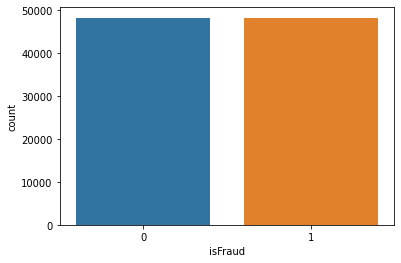

In [ ]:
from sklearn.utils import resample
y=train['isFraud']
df_majority = train[y == 0]

df_minority = train[y == 1]
size_major = len(df_majority)

y_majority = y[y == 0]
y_minority = y[y == 1]

# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                   replace=True,    # sample with replacement
                   n_samples=size_major,    # to match majority class
                   random_state=42)  # reproducible results

train = pd.concat([df_majority, df_minority_upsampled])
y_minority_upsampled = y_minority[df_minority_upsampled.index]
y = pd.concat([y_majority, y_minority_upsampled])

sns.countplot(x = y);
print(train.head(),y.head())
print(train.shape,y.shape)

In [ ]:
del df_majority, df_minority, size_major, y_majority, y_minority, df_minority_upsampled, y_minority_upsampled, 
gc.collect

<function gc.collect>

filling in missing values

In [ ]:
imputer = SimpleImputer(strategy='median')
imputer.fit(train)
X_train = imputer.transform(train)
print(X_train.shape)
y.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


(96580, 403)


(96580,)

In [ ]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
y=train['isFraud']
train.drop("isFraud", axis=1, inplace=True)
train.drop("TransactionID", axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_train, y,test_size=0.3, stratify=y)


In [ ]:
# IGNNORE THIS CELL FOR BETTER RESULTS

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=42)
os_data_X,os_data_y=os.fit_resample(train_X, train_y)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
for i in range (1,10,2):
  neigh = KNeighborsClassifier(n_neighbors=i)
  # neigh.fit(X_train, Y_train)
  neigh.fit(train_X,train_y)
  predict = neigh.predict(test_X)
  print("classification report of k= ", i)
  print(classification_report(predict,test_y))

classification report of k=  1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14189
           1       1.00      0.98      0.99     14785

    accuracy                           0.99     28974
   macro avg       0.99      0.99      0.99     28974
weighted avg       0.99      0.99      0.99     28974

classification report of k=  3
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13878
           1       1.00      0.96      0.98     15096

    accuracy                           0.98     28974
   macro avg       0.98      0.98      0.98     28974
weighted avg       0.98      0.98      0.98     28974

classification report of k=  5
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13577
           1       1.00      0.94      0.97     15397

    accuracy                           0.97     28974
   macro avg       0.97      0.97  

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(train_X, train_y)
predict = classifier.predict(test_X)
print(classification_report(predict,test_y))


              precision    recall  f1-score   support

           0       0.58      0.67      0.62     24176
           1       0.72      0.63      0.67     32141

    accuracy                           0.65     56317
   macro avg       0.65      0.65      0.65     56317
weighted avg       0.66      0.65      0.65     56317



In [ ]:
train.head()


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,0
100000,-1.505604,-0.469470,0.600946,0.831693,2.490853,0.580664,0.074747,0.013602,-0.295815,0.379319,...,0.560351,-0.434496,0.030399,-0.411296,-0.222434,-0.73608,-0.07691,0.012573,1.102639,NaN
100001,-1.505573,-0.259695,-1.370135,0.252857,2.490853,0.580664,0.074747,0.013602,-0.295815,-0.226720,...,0.560351,-0.601047,-0.467579,-0.411296,-0.222434,-0.73608,-0.07691,0.012573,1.102639,NaN
100002,-1.505463,-0.078848,-1.448372,0.907193,-0.330189,0.630014,0.183978,0.013602,-0.303574,-0.379578,...,0.560351,-0.316522,0.724946,-0.411296,-0.222434,-0.73608,-0.07691,0.012573,1.102639,NaN
100003,-1.505442,0.008764,0.333671,1.007860,-0.330189,-0.134913,-0.193365,0.013602,-0.290643,-0.379578,...,0.560351,-0.316522,0.724946,-0.411296,-0.222434,-0.73608,-0.07691,0.012573,1.102639,NaN
100004,-1.505350,-0.120836,1.018961,1.177736,-0.330189,0.630014,0.074747,0.013602,-0.295815,-0.379578,...,0.560351,-0.316522,0.724946,-0.411296,-0.222434,-0.73608,-0.07691,0.012573,1.102639,NaN


In [ ]:
train_X.isna().sum().sum()

0

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

# Fit the model
nb.fit(train_X, train_y)

# Print the accuracy score
print("Accuracy:",nb.score(test_X, test_y))
y_pred = nb.predict(test_X)

cr = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(cr)


Accuracy: 0.6906983125257237


Classification Report

              precision    recall  f1-score   support

           0       0.63      0.95      0.75     14578
           1       0.89      0.44      0.59     14578

    accuracy                           0.69     29156
   macro avg       0.76      0.69      0.67     29156
weighted avg       0.76      0.69      0.67     29156



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
clf_rf_down = RandomForestClassifier(random_state=42)
model_rf_down = clf_rf_down.fit(train_X, train_y)
y_pred = model_rf_down.predict(test_X)
cr = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(cr)




Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14487
           1       1.00      1.00      1.00     14487

    accuracy                           1.00     28974
   macro avg       1.00      1.00      1.00     28974
weighted avg       1.00      1.00      1.00     28974



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix\n")
print(cm)

Confusion Matrix

[[28159     0]
 [    0 28158]]


In [ ]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier(seed=42,
                      n_estimators=500,
                      max_depth=10,
                      learning_rate=0.2)

# model.fit(X_train, y_train)
model_xgb_down = XGB_model.fit(train_X, train_y)
# y_prob = .predict_proba(test_X)[:, 1]
y_pred = model_xgb_down.predict(test_X)

cr = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(cr)




Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14487
           1       1.00      1.00      1.00     14487

    accuracy                           1.00     28974
   macro avg       1.00      1.00      1.00     28974
weighted avg       1.00      1.00      1.00     28974



In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_X, train_y)
y_pred = clf.predict(test_X)
cr = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(cr)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e20)
model.fit(train_X, train_y)
preds = model.predict(test_X)
cr = classification_report(test_y, preds)
print("\n\nClassification Report\n")
print(cr)



Classification Report

              precision    recall  f1-score   support

           0       0.65      0.87      0.74     14428
           1       0.81      0.53      0.64     14428

    accuracy                           0.70     28856
   macro avg       0.73      0.70      0.69     28856
weighted avg       0.73      0.70      0.69     28856

